In [1]:
import numpy as np
from keras import backend as K
from keras import losses
import tensorflow as tf

max_noise = 0.15
step_size = 1.0/255.0

Using TensorFlow backend.


In [2]:
x = np.array([2, -1, 3, -2, 2, 2, 1, -4, 5, 1])
w = np.array([-1, -1, 1, -1, 1, -1, 1, 1, -1, 1])

## Toy Example showing the phenomenal of fool a binary logistic  regression

'p' is the probability of be class 1.
If p > 0.5 it belongs to the class 1 otherwise not.

In [3]:
p = 1/(1+np.power(np.e, -np.dot(x, w)))
print(p)

0.04742587317756679


#### Let's try to foll the classifier

Doing the dot product again we see that suddenly the score becomes 2. This is not surprising: There are 10 dimensions and we’ve tweaked the input by 0.5 in every dimension in such a way that we gain 0.5 in each one, adding up to a total of 5 additional score, rising it from -3 to 2. Now when we look at probability of class 1 we get 1/(1+e^(-2)) = 0.88. That is, we tweaked the original x by a small amount and we improved the class 1 probability from 5% to 88%!

In [4]:
# xad = x + 0.5w gives:
xad = [1.5, -1.5, 3.5, -2.5, 2.5, 1.5, 1.5, -3.5, 4.5, 1.5]
# xad = [1.1, -1.1, 3.1, -2.1, 2.1, 1.1, 1.1, -3.1, 4.1, 1.1]

In [5]:
p = 1/(1+np.power(np.e, -np.dot(xad, w)))
print(p)

0.8807970779778823


## Reproducing the  “Deep MNIST for Experts” tutorial

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [7]:
def plot_figures(X_10_samples_2, X_10_noise, num_imgs=10):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.figure(figsize=((num_imgs*3),15))

    idx_img = 0;
    for i in range(1, (num_imgs*3), 3):
        ax1 = fig.add_subplot(num_imgs, 3, i)
        ax1.imshow(X_10_samples_2[idx_img])
        ax2 = fig.add_subplot(num_imgs, 3, i+1)
        ax2.imshow(X_10_noise[idx_img])
        ax3 = fig.add_subplot(num_imgs, 3, i+2)
        ax3.imshow( (X_10_samples_2[idx_img] + X_10_noise[idx_img]) )

        idx_img = idx_img + 1

In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
arange_ = np.arange(len(y_train))

In [9]:
# with tf.device('/cpu:0'):
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
y_aux = np.zeros( (len(y_train), 10) )
y_aux[arange_, y_train] = 1
y_train = y_aux
model.fit(x_train, y_train, epochs=5)


for i in range(len(model.layers)):
    layer = model.layers[i]
    layer.trainable = False

model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

model.summary()

dist_loss = K.variable(0.)
fake_class = K.variable(0)
K.set_session(tf.Session(graph=model.output.graph))
init = K.tf.global_variables_initializer()
K.get_session().run(init)

arange_ = np.arange(len(y_test))
y_aux = np.zeros( (len(y_test), 10) )
y_aux[arange_, y_test] = 1
y_test = y_aux

model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 13s 222us/step - loss: 0.2214 - acc: 0.9347
Epoch 2/5
60000/60000 [==============================] - 12s 200us/step - loss: 0.0992 - acc: 0.9695
Epoch 3/5
60000/60000 [==============================] - 13s 221us/step - loss: 0.0708 - acc: 0.9785
Epoch 4/5
60000/60000 [==============================] - 12s 206us/step - loss: 0.0523 - acc: 0.9834
Epoch 5/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.0426 - acc: 0.9861
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________

[0.07303114196700045, 0.9791]

#### Selecting samples from the 2

In [10]:
y_train_idx = np.argmax(y_train, axis=1)
print(y_train_idx)
X_samples_2 = np.copy(x_train[y_train_idx==2])
X_samples_2_orig = np.copy(x_train[y_train_idx==2])
X_noises = np.zeros((X_samples_2.shape[0], 28, 28))

Y_samples_2 = y_train[np.argmax(y_train, axis=1)==2]
Y_fakes = np.copy(Y_samples_2)
Y_fakes[:, 2] = 0
Y_fakes[:, 6] = 1

print("X_samples_2.shape "+ str(X_samples_2.shape))
print("Y_samples_2.shape "+str(Y_samples_2.shape))
print("X_noises.shape "+str(X_noises.shape))
print("Y_fakes.shape "+str(Y_fakes.shape))

[5 0 4 ... 5 6 8]
X_samples_2.shape (5958, 28, 28)
Y_samples_2.shape (5958, 10)
X_noises.shape (5958, 28, 28)
Y_fakes.shape (5958, 10)


#### In the fisrt way to try fool the Neural Network I will follow this steps.
* Get image samples of 2 and target it as 6
* Apply the feedforward in CNN
* Get the gradient and apply it on image
* Get the difference of new image and original image as noise

### Applying Ian Goodfellow method.  This method utiliza just the sign of gradient. And global pertubations.

In [21]:
# Getting gradient
input_img = model.input
fake_class = K.zeros(shape=(1, 10))

layer = model.layers[-1]
print(layer.output)

# distance Loss
# np.random.seed(1)
# for x in np.random.choice(model.layers[:-1], size = len(model.layers) - 1):
#     x_var = x.output
#     dist_loss = dist_loss + np.random.uniform(0,2) * K.sum(K.square(x_var)) / K.prod(K.cast(K.shape(x_var), 'float32'))
    

# adversarial loss
adversarial_loss = losses.categorical_crossentropy(fake_class, layer.output)# - dist_loss

grads = K.gradients(adversarial_loss, model.input)[0]
print(grads)
grads = grads / K.maximum(K.abs(K.max(grads)), K.abs(K.min(grads)))

print(input_img.shape)
print(fake_class.shape)
grads_func = K.function(inputs=[input_img, fake_class], outputs=[grads])

Tensor("dense_1/Softmax:0", shape=(?, 10), dtype=float32)
Tensor("gradients_2/flatten/Reshape_grad/Reshape:0", shape=(?, 28, 28), dtype=float32)
(?, 28, 28)
(1, 10)


In [23]:
# fig = plt.figure(figsize=(30,15))
unique_noise = X_noises[0]
total_found = 0
idx_found =[]

for it in range(50):
    print("Iteration: "+ str(it))
    for sample_idx in range(X_samples_2.shape[0]):
        sample = np.reshape(X_samples_2_orig[sample_idx], (1,28,28))
        predicted = model.predict(np.array(sample))
        predicted_idx = np.argmax(predicted)

        if predicted_idx != 2 or sample_idx in idx_found:
            continue
        if total_found >= 10:
            break

        for i in range(50):
            fuzzy_img = (X_samples_2[sample_idx] + unique_noise)
            fuzzy_img = np.clip(fuzzy_img, 0, 1)
            fuzzy_img = np.reshape(fuzzy_img, (1, 28, 28))

            predicted = model.predict(fuzzy_img)[0]
            predicted_idx = np.argmax(predicted)
            if predicted_idx == 6:
                idx_found.append(sample_idx)
                X_noises[total_found] = np.copy(unique_noise)
                total_found = total_found + 1
                if total_found < 10:
                    unique_noise = X_noises[total_found]
                    
                print("img "+ str(sample_idx) + "  pred: " + str(predicted_idx) + "  Confiance: " + str(predicted[6]) )
                break

            #Update noise
            Y_fakes_hot_ones = np.zeros((1,10), dtype='int8')
            Y_fakes_hot_ones[0, 6] = 1
            grads = grads_func([fuzzy_img, Y_fakes_hot_ones])
            grads = np.array(grads[0][0])
            unique_noise = np.clip((unique_noise - (np.sign(grads)*step_size)), -max_noise, max_noise)
        
#         break
#     break
# print(sample, ' - predicted - ', predicted_idx, '  --  ', predicted[0, 2], '  --  ', predicted[0, 6], '  --  ', predicted[0, predicted_idx])
# print('-----------------------------------------------------------------------------------------------\n')

Iteration: 0
img 1560  pred: 6  Confiance: 0.7086325
img 2065  pred: 6  Confiance: 0.5061566
img 2730  pred: 6  Confiance: 0.46758485
img 3900  pred: 6  Confiance: 0.8139237
img 3909  pred: 6  Confiance: 0.73357105
img 4125  pred: 6  Confiance: 0.5027775
img 4652  pred: 6  Confiance: 0.579142
img 5595  pred: 6  Confiance: 0.53026825
Iteration: 1
Iteration: 2
img 1654  pred: 6  Confiance: 0.45345715
img 2741  pred: 6  Confiance: 0.4065541
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Itera

Images used: [1560, 2065, 2730, 3900, 3909, 4125, 4652, 5595, 1654, 2741]
(10, 28, 28)
(10, 28, 28)

Predicting original images
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predicting images with pertubation
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


<Figure size 1280x960 with 0 Axes>

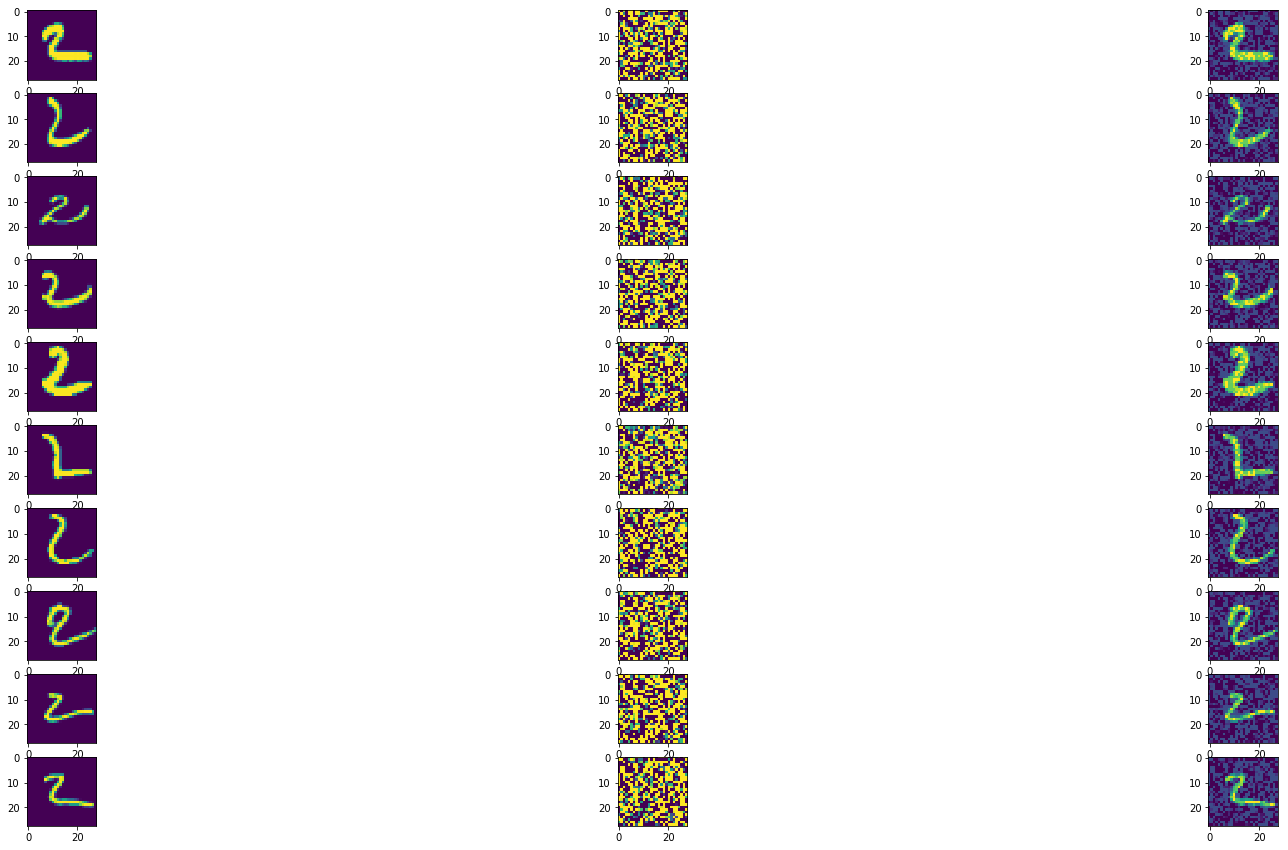

In [24]:
print("Images used: " + str(idx_found))
imgs_used = X_samples_2[idx_found]
noises_used = X_noises[:imgs_used.shape[0]]
print(imgs_used.shape)
print(noises_used.shape)

print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(np.clip((imgs_used + noises_used), 0, 1))[i]) for i in range(imgs_used.shape[0])]
print(pred)


plot_figures(imgs_used, noises_used)

### Trying AG approach

In [23]:
pred = model.predict(X_samples_2_orig)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
pred_idx = np.array(pred_idx)

X_samples_2_GA = np.copy(X_samples_2_orig[pred_idx==2])
pred = model.predict(X_samples_2_GA)
pred_idx = [ pred[i][2]-pred[i][2] for i in range(X_samples_2_GA.shape[0]) ]
pred_idx = np.array(pred_idx).argsort()
X_samples_2_GA = X_samples_2_GA[pred_idx]
# Selectiing top 50 samples that has more probability to change
X_samples_2_GA = X_samples_2_GA[-100:]
print(X_samples_2_GA.shape)

def create_population(n):
    pop = []
    for i in range(n):
        individual = np.zeros(28*28) # np.array([np.random.normal()/5 for _ in range(28*28)])
        individual = np.reshape(individual, (28,28))
        for i in range(28):
            for j in range(28):
                individual[i,j] = ((np.random.randint(256)/255.0)/10.0)
                if np.random.rand()>0.5:
                    individual[i,j] = -individual[i,j]
        individual = np.reshape(individual, (28*28))
        individual = np.clip(individual, -max_noise*(3/2), max_noise*(3/2))
        pop.append(individual)
        
    return np.array(pop)

(100, 28, 28)


In [24]:
def evaluate_population(pop):
    ranking = []    
    X_samples_2_eval = X_samples_2_GA
    
    for individual in pop:
        X_noise = np.reshape(individual, (1, 28, 28))
        fuzzy_imgs = (X_samples_2_GA + X_noise)
        fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)

        pred = model.predict(fuzzy_imgs)
        pred_idx = [ np.argmax(pred[i]) for i in range(fuzzy_imgs.shape[0]) ]
        pred_idx = np.array(pred_idx)
        value = np.sum(pred, axis=0)[6]
        value = value + (np.sum(pred_idx==6)*100)
        ranking.append(value)
        
    return ranking

In [25]:
def mutation(individual, probability):
    individual = np.reshape(individual, (28,28))
    for i in range(28):
        for j in range(28):
#             if (i<4 or i>23) or (j<4 or j>23):
            if np.random.rand() < probability:
                individual[i, j] = individual[i, j] + ((np.random.randint(256)/255.0)/10.0) # np.random.normal()/10

    individual = np.reshape(individual, (28*28))
    individual = np.clip(individual, -max_noise*(3/2), max_noise*(3/2))
    return np.array(individual)

def crossover(ind1 , ind2):
    position = np.random.randint(len(ind1))
    new_individual1 = np.concatenate((ind1[:position], ind2[position:]))
    new_individual2 = np.concatenate((ind2[:position], ind1[position:]))
    return np.array(new_individual1), np.array(new_individual2)

In [26]:
num_epoch = 10000
pop_size = 1000
best_inds = 100

pop = create_population(pop_size)
best_individual = None

# pred = model.predict(X_samples_2_GA)
# pred_idx = [ str(pred[i][2])+ " - " + str(pred[i][6]) for i in range(X_samples_2_GA.shape[0]) ]
# pred_idx = np.array(pred_idx)
# print(pred_idx)


for epoch in range(num_epoch):
    # Analize current population. Evaluate them and ordering by score
    ranking = np.array(evaluate_population(pop))
    ordered_idx = ranking.argsort()
    pop_ordered = pop[ordered_idx]
    top_inds = np.array(pop_ordered[-best_inds:])
    other_ind = np.array(pop[ordered_idx][:-best_inds])
    
    # Stop criterea
    if ranking[ordered_idx[-1]] > 1000: # The best individual find 10 images that it can perturb
        idx = ordered_idx[-1]
        best_individual = pop_ordered[-1]
        print("Idx: " + str(idx))
        print("Score of Best Individual: " + str(evaluate_population([best_individual])))
        print("An individual that can modify 10 images was found in epoch "+str(epoch)+". Score: " + str(ranking[idx]))
        break
    
    # Creating a new population
    new_pop = []
    for _ in range(int(pop_size/4)):
        ind1 = top_inds[np.random.randint(len(top_inds))]
        ind2 = top_inds[np.random.randint(len(top_inds))]
        new_ind1, new_ind2 = crossover(ind1, ind2)
        new_pop.append(new_ind1)
        new_pop.append(new_ind2)
    
    pop_with_mutation = []
    for i in range(len(new_pop)):
        pop_with_mutation.append(mutation(new_pop[i], probability=0.05))

    pop_with_mutation = np.concatenate((create_population(pop_size - best_inds - len(pop_with_mutation)), pop_with_mutation))
    pop = np.concatenate((top_inds, pop_with_mutation))
    if (epoch % 50)==0:
        print(str(epoch), ' - best value: ', str(ranking[ordered_idx[-1]]) +"  worst value: " + str(str(ranking[ordered_idx[0]])) )
        print()
        
ranking = np.array(evaluate_population(pop))
ordered_idx = ranking.argsort()
ordered_individuals = np.array(pop[ordered_idx])

idx = ordered_idx[-1]
print("\nIdx: " + str(idx))
print("max noise: " + str(np.max(best_individual)))
print('best value found: ', str(ranking[idx]) )

0  - best value:  0.011924647726118565  worst value: 0.0009476025588810444

Idx: 831
Score of Best Individual: [1010.3467903137207]
An individual that can modify 10 images was found in epoch 47. Score: 1010.3467903137207

Idx: 831
max noise: 0.22499999999999998
best value found:  1010.3467903137207


[1010.3467903137207]
Images used: [ 2  4  9 14 16 30 32 41 77 93]

Predicting original images
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predicting images with pertubation
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


<Figure size 1280x960 with 0 Axes>

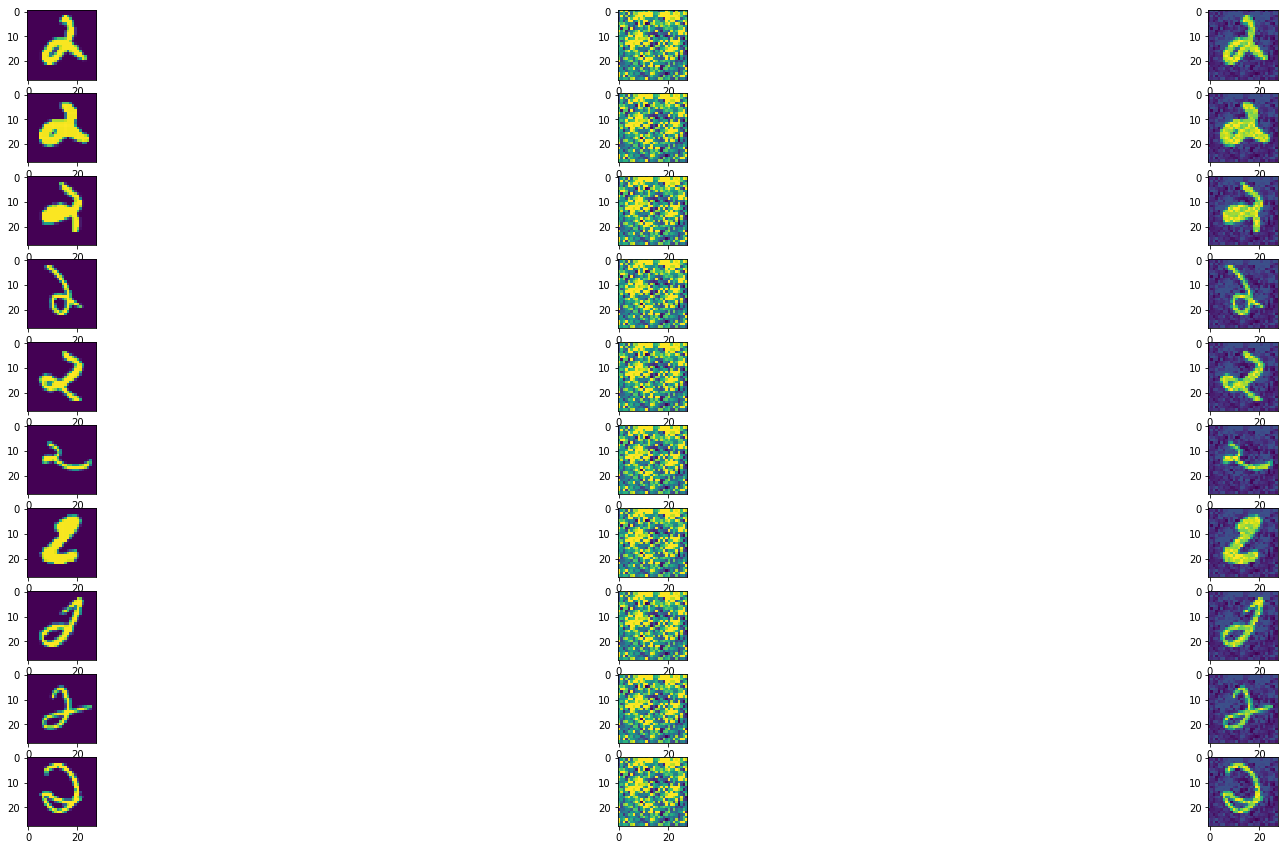

In [29]:
individual = best_individual

X_noise = np.reshape(individual, (1, 28, 28))
fuzzy_imgs = (X_samples_2_GA + X_noise)
fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)

pred = model.predict(fuzzy_imgs)
pred_idx = [ np.argmax(pred[i]) for i in range(fuzzy_imgs.shape[0]) ]
pred_idx = np.array(pred_idx)

print (evaluate_population([best_individual]))

imgs_used = X_samples_2_GA[np.where(pred_idx==6)[0]]
imgs_fuzzy = imgs_used + X_noise
imgs_fuzzy = np.clip(imgs_fuzzy, 0, 1)

print("Images used: " + str(np.where(pred_idx==6)[0]))

print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(imgs_fuzzy)[i]) for i in range(imgs_used.shape[0])]
print(pred)

X_noise_used = np.zeros((imgs_used.shape[0], 28, 28))
for i in range(imgs_used.shape[0]):
    X_noise_used[i] = np.copy(X_noise)
plot_figures(imgs_used, X_noise_used)

## GAN GENARATOR

In [35]:
# Prepare dataset
pred = model.predict(X_samples_2_orig)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
pred_idx = np.array(pred_idx)

X_samples_2_GAN = np.copy(X_samples_2_orig[pred_idx==2])
pred = model.predict(X_samples_2_GAN)
print(X_samples_2_GAN.shape)

Y_fakes_GAN = np.zeros((X_samples_2_GAN.shape[0], 10))
Y_fakes_GAN[:, 6] = 1
print(Y_fakes_GAN.shape)

# This model receive as input and output another image with the same size, The output is the 
# image perturbed
model_generator = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(8, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(28*28, activation=tf.nn.sigmoid)
])

# This model connect the model generator of images perturbed with principal model that predict 
# which number is on image
composed_model = tf.keras.models.Sequential([
    model_generator,
    model
])

# Compile the 2 models
model_generator.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

composed_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trainning 'composed_model' with fake Y's. As the 'model' was frozen, only the 'moodel_generator'
# is updated. This should make the 'model_geneator' create images that the 'model' recognize as 6.
composed_model.fit(X_samples_2_GAN, Y_fakes_GAN, epochs=5)

(5935, 28, 28)
(5935, 10)
Epoch 1/5
5935/5935 [==============================] - 2s 335us/step - loss: 0.1325 - acc: 0.9806
Epoch 2/5
5935/5935 [==============================] - 2s 255us/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 3/5
5935/5935 [==============================] - 2s 260us/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 4/5
5935/5935 [==============================] - 2s 272us/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 5/5
5935/5935 [==============================] - 2s 257us/step - loss: 1.1921e-07 - acc: 1.0000


Images used: range(0, 10)

Predicting original images
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predicting images with pertubation
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


<Figure size 1280x960 with 0 Axes>

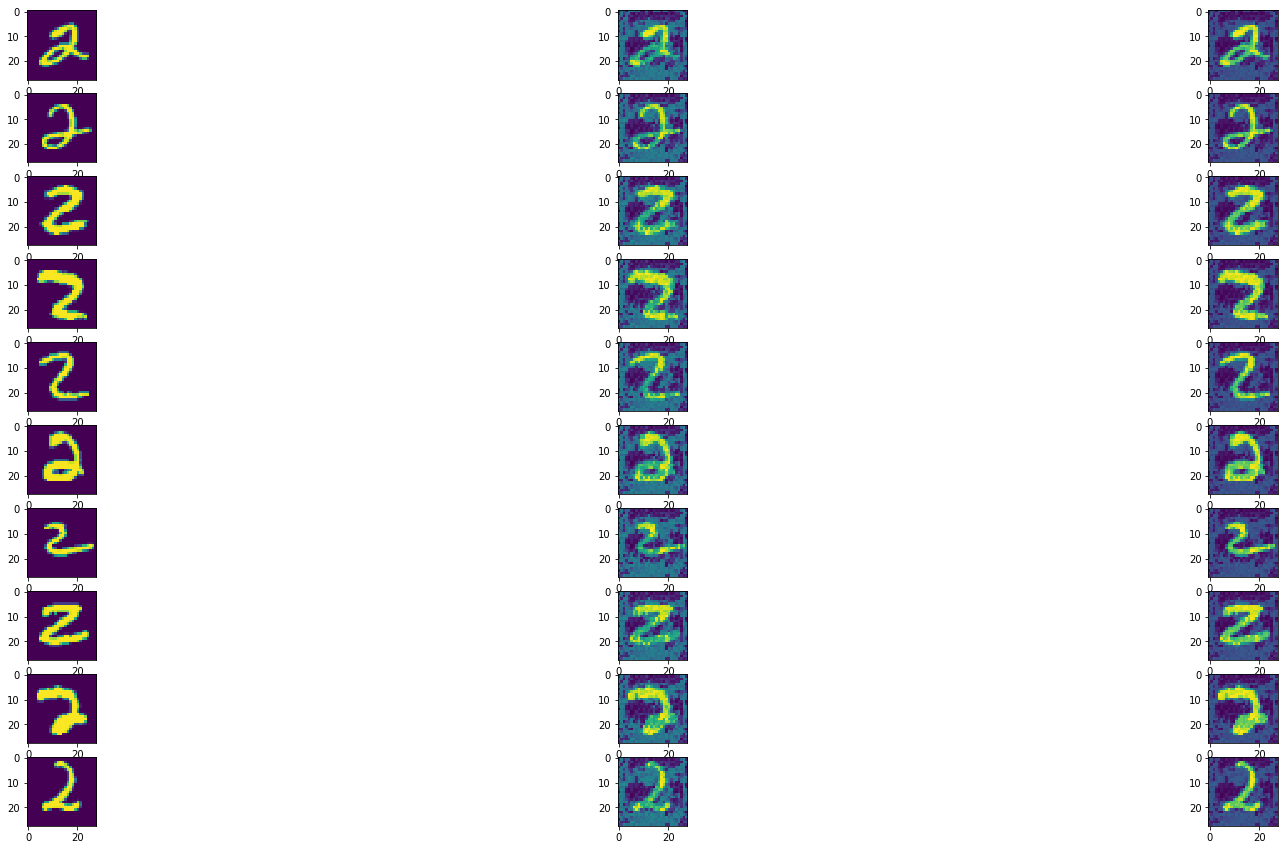

In [39]:
X_noise = np.reshape(individual, (1, 28, 28))
fuzzy_imgs = (X_samples_2_GA + X_noise)
fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)


imgs_used = X_samples_2_GAN[:10]
imgs_generated = model_generator.predict(imgs_used)
imgs_fuzzy = np.reshape(imgs_generated, (imgs_generated.shape[0], 28, 28))
imgs_fuzzy = np.clip(imgs_fuzzy, 0, 1)
noises_used = imgs_used - imgs_fuzzy

print("Images used: " + str(range(10)))
print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(imgs_fuzzy)[i]) for i in range(imgs_used.shape[0])]
print(pred)

plot_figures(imgs_used, noises_used)

### What we can do changing just one pixel??

##### Let's try to verify this by a greed search combined with binary-search

In [72]:
pred = model.predict(X_samples_2_orig)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_orig.shape[0]) ]
pred_idx = np.array(pred_idx)

X_samples_2_ONE = np.copy(X_samples_2_orig[pred_idx==2])
pred = model.predict(X_samples_2_ONE)
pred_idx = [ np.argmax(pred[i]) for i in range(X_samples_2_ONE.shape[0]) ]
pred_idx = np.array(pred_idx)
print(X_samples_2_ONE.shape)
print(pred_idx.shape)

imgs_idx = []
pertubation_values = []

def test_noise(X_noise):
    fuzzy_imgs = (X_samples_2_ONE + X_noise)
    fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)

    pred = model.predict(fuzzy_imgs)
    pred_idx = [ np.argmax(pred[i]) for i in range(fuzzy_imgs.shape[0]) ]
    pred_idx = np.array(pred_idx)
    value = np.sum(pred, axis=0)[6]
    value = value + (np.sum(pred_idx==6)*1000)
    
    return value, np.where(pred_idx==6)

(5935, 28, 28)
(5935,)


In [73]:
# Verify each pixel changing its value using binary-search
for i in range(X_samples_2_ONE.shape[1]):
    for j in range(X_samples_2_ONE.shape[2]):
        X_noise = np.zeros((1, X_samples_2_ONE.shape[1], X_samples_2_ONE.shape[2]))
        value_base, _ = test_noise(X_noise)
        pertubation = 64
        up_limit = 128
        down_limit = 0
        X_noise[0,i,j] = pertubation/128
        for try_ in range(20): # Positive noise
            recent_value, imgs_pred_6 = test_noise(X_noise)
#             print(str(i) + ", "+ str(j)+ " : "+str(recent_value) + "  --  " + str(pertubation/128) + " -- "+str(np.array(imgs_pred_6).size))
            if np.array(imgs_pred_6).size > 0: # Add images that are predicted as 6 changing one pixel
                for img_idx in imgs_pred_6:
                    if img_idx not in imgs_idx:
                        imgs_idx.append(img_idx)
                        pertubation_values.append([i,j, pertubation/128])
            
            if recent_value > value_base: # improve the result
                pertubation = (pertubation + up_limit)/2.0
            else:
                pertubation = (pertubation + down_limit)/2.0
            
            X_noise[0,i,j] = pertubation/128 # update noise
            if len(imgs_idx) >= 10 or pertubation==1.0:
                break
                
        pertubation = -64
        up_limit = 0
        down_limit = -128
        X_noise[0,i,j] = 0
        value_base, _ = test_noise(X_noise)
        X_noise[0,i,j] = pertubation/128
        for try_ in range(20): # Negative noise
            recent_value, imgs_pred_6 = test_noise(X_noise)
#             print(str(i) + ", "+ str(j)+ " : "+str(recent_value) + "  --  " + str(pertubation/128) + " -- "+str(np.array(imgs_pred_6).size))
            if np.array(imgs_pred_6).size > 0: # Add images that are predicted as 6 changing one pixel
                for img_idx in imgs_pred_6:
                    if img_idx not in imgs_idx:
                        imgs_idx.append(img_idx)
                        pertubation_values.append([i,j, pertubation/128])
            
            if recent_value > value_base: # improve the result
                pertubation = (pertubation + down_limit)/2.0
            else:
                pertubation = (pertubation + up_limit)/2.0
            
            X_noise[0,i,j] = pertubation/128 # update noise
            if len(imgs_idx) >= 10 or pertubation==1.0:
                break
            
        print(str(i) + ", "+ str(j)+ " : " + str(np.array(pertubation_values).size) + "  -- " + str(pertubation_values))
        
        if len(imgs_idx) >= 10:
            break
    if len(imgs_idx) >= 10:
        break
            

0, 0 : 0  -- []
0, 1 : 0  -- []
0, 2 : 0  -- []
0, 3 : 0  -- []
0, 4 : 0  -- []
0, 5 : 0  -- []
0, 6 : 0  -- []
0, 7 : 0  -- []
0, 8 : 0  -- []
0, 9 : 0  -- []
0, 10 : 0  -- []
0, 11 : 0  -- []
0, 12 : 0  -- []
0, 13 : 0  -- []
0, 14 : 0  -- []
0, 15 : 0  -- []
0, 16 : 0  -- []
0, 17 : 0  -- []
0, 18 : 0  -- []
0, 19 : 0  -- []
0, 20 : 0  -- []
0, 21 : 0  -- []
0, 22 : 0  -- []
0, 23 : 0  -- []
0, 24 : 0  -- []
0, 25 : 0  -- []
0, 26 : 0  -- []
0, 27 : 0  -- []
1, 0 : 0  -- []
1, 1 : 0  -- []
1, 2 : 0  -- []
1, 3 : 0  -- []
1, 4 : 0  -- []
1, 5 : 0  -- []
1, 6 : 0  -- []
1, 7 : 0  -- []
1, 8 : 0  -- []
1, 9 : 0  -- []
1, 10 : 0  -- []
1, 11 : 0  -- []
1, 12 : 0  -- []
1, 13 : 0  -- []
1, 14 : 0  -- []
1, 15 : 0  -- []
1, 16 : 0  -- []
1, 17 : 0  -- []
1, 18 : 3  -- [[1, 18, 0.75]]
1, 19 : 3  -- [[1, 18, 0.75]]
1, 20 : 3  -- [[1, 18, 0.75]]
1, 21 : 3  -- [[1, 18, 0.75]]
1, 22 : 3  -- [[1, 18, 0.75]]
1, 23 : 3  -- [[1, 18, 0.75]]
1, 24 : 3  -- [[1, 18, 0.75]]
1, 25 : 3  -- [[1, 18, 0.75]

10, 17 : 3  -- [[1, 18, 0.75]]
10, 18 : 3  -- [[1, 18, 0.75]]
10, 19 : 3  -- [[1, 18, 0.75]]
10, 20 : 3  -- [[1, 18, 0.75]]
10, 21 : 3  -- [[1, 18, 0.75]]
10, 22 : 3  -- [[1, 18, 0.75]]
10, 23 : 3  -- [[1, 18, 0.75]]
10, 24 : 3  -- [[1, 18, 0.75]]
10, 25 : 3  -- [[1, 18, 0.75]]
10, 26 : 3  -- [[1, 18, 0.75]]
10, 27 : 3  -- [[1, 18, 0.75]]
11, 0 : 3  -- [[1, 18, 0.75]]
11, 1 : 3  -- [[1, 18, 0.75]]
11, 2 : 3  -- [[1, 18, 0.75]]
11, 3 : 3  -- [[1, 18, 0.75]]
11, 4 : 3  -- [[1, 18, 0.75]]
11, 5 : 3  -- [[1, 18, 0.75]]
11, 6 : 3  -- [[1, 18, 0.75]]
11, 7 : 3  -- [[1, 18, 0.75]]
11, 8 : 3  -- [[1, 18, 0.75]]
11, 9 : 3  -- [[1, 18, 0.75]]
11, 10 : 3  -- [[1, 18, 0.75]]
11, 11 : 3  -- [[1, 18, 0.75]]
11, 12 : 3  -- [[1, 18, 0.75]]
11, 13 : 3  -- [[1, 18, 0.75]]
11, 14 : 3  -- [[1, 18, 0.75]]
11, 15 : 3  -- [[1, 18, 0.75]]
11, 16 : 3  -- [[1, 18, 0.75]]
11, 17 : 3  -- [[1, 18, 0.75]]
11, 18 : 3  -- [[1, 18, 0.75]]
11, 19 : 3  -- [[1, 18, 0.75]]
11, 20 : 3  -- [[1, 18, 0.75]]
11, 21 : 3  -- [[1

20, 5 : 3  -- [[1, 18, 0.75]]
20, 6 : 3  -- [[1, 18, 0.75]]
20, 7 : 3  -- [[1, 18, 0.75]]
20, 8 : 3  -- [[1, 18, 0.75]]
20, 9 : 3  -- [[1, 18, 0.75]]
20, 10 : 3  -- [[1, 18, 0.75]]
20, 11 : 3  -- [[1, 18, 0.75]]
20, 12 : 3  -- [[1, 18, 0.75]]
20, 13 : 3  -- [[1, 18, 0.75]]
20, 14 : 3  -- [[1, 18, 0.75]]
20, 15 : 3  -- [[1, 18, 0.75]]
20, 16 : 3  -- [[1, 18, 0.75]]
20, 17 : 3  -- [[1, 18, 0.75]]
20, 18 : 3  -- [[1, 18, 0.75]]
20, 19 : 3  -- [[1, 18, 0.75]]
20, 20 : 3  -- [[1, 18, 0.75]]
20, 21 : 3  -- [[1, 18, 0.75]]
20, 22 : 3  -- [[1, 18, 0.75]]
20, 23 : 3  -- [[1, 18, 0.75]]
20, 24 : 3  -- [[1, 18, 0.75]]
20, 25 : 3  -- [[1, 18, 0.75]]
20, 26 : 3  -- [[1, 18, 0.75]]
20, 27 : 3  -- [[1, 18, 0.75]]
21, 0 : 3  -- [[1, 18, 0.75]]
21, 1 : 3  -- [[1, 18, 0.75]]
21, 2 : 3  -- [[1, 18, 0.75]]
21, 3 : 3  -- [[1, 18, 0.75]]
21, 4 : 3  -- [[1, 18, 0.75]]
21, 5 : 3  -- [[1, 18, 0.75]]
21, 6 : 3  -- [[1, 18, 0.75]]
21, 7 : 3  -- [[1, 18, 0.75]]
21, 8 : 3  -- [[1, 18, 0.75]]
21, 9 : 3  -- [[1, 18,

##### Modifing just 1 pixel, using the above methodologie show that adding 0.75 on pixel (1,18) can perturb the an image of 2 to be 
##### recognized as 6.

Images used: (array([1836]),)

Predicting original images
[2]

Predicting images with pertubation
[6]


<Figure size 1280x960 with 0 Axes>

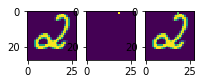

In [77]:
X_noise = np.zeros((1, 28, 28), dtype='float32')
X_noise[0,1,18] = .75

fuzzy_imgs = (X_samples_2_ONE + X_noise)
fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)
pred = model.predict(fuzzy_imgs)
pred = np.array( [np.argmax(pred[i]) for i in range(X_samples_2_ONE.shape[0])] )
imgs_idx_used = np.where(pred==6)

imgs_used = X_samples_2_ONE[imgs_idx_used]
noises_used = np.zeros((imgs_used.shape[0], 28, 28))
for i in range(imgs_used.shape[0]):
    noises_used[i] = X_noise

fuzzy_imgs = imgs_used + noises_used

print("Images used: " + str(imgs_idx_used))
print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(imgs_fuzzy)[i]) for i in range(imgs_used.shape[0])]
print(pred)

plot_figures(imgs_used, noises_used, num_imgs=len(pred))

##### Finding pertubations in one pixel using a sistematic approach

In [87]:
imgs_idx = []
pertubation_values = []

# 6 hrs to process 6 5 lines. Expected to consume 33 hrs.

# Verify each pixel changing its value using systematic approach
# Check if it can find at least 10 images of 2 that can be recognized as 6 perturbing just one pixel
for i in range(X_samples_2_ONE.shape[1]):
    for j in range(X_samples_2_ONE.shape[2]):
        X_noise = np.zeros((1, X_samples_2_ONE.shape[1], X_samples_2_ONE.shape[2]))
        pertubation = -255
        for step in range(2*255):
            X_noise[0,i,j] = pertubation/255
            _, imgs_pred_6 = test_noise(X_noise)
            
            if np.array(imgs_pred_6).size > 0: # Add images that are predicted as 6 changing one pixel
                for img_idx in imgs_pred_6:
                    if img_idx not in imgs_idx:
                        imgs_idx.append(img_idx)
                        pertubation_values.append((img_idx, i,j, pertubation/255))
            
            pertubation = pertubation + 1
            
            if len(imgs_idx) >= 10:
                break
        print(str(i) + ", "+ str(j)+ " : " + str(np.array(pertubation_values).size) + "  -- " + str(pertubation_values))
        if len(imgs_idx) >= 10:
            break
    if len(imgs_idx) >= 10:
            break

0, 0 : 0  -- []
0, 1 : 0  -- []
0, 2 : 0  -- []
0, 3 : 0  -- []
0, 4 : 0  -- []
0, 5 : 0  -- []
0, 6 : 0  -- []
0, 7 : 0  -- []
0, 8 : 0  -- []
0, 9 : 0  -- []
0, 10 : 0  -- []
0, 11 : 0  -- []
0, 12 : 0  -- []
0, 13 : 0  -- []
0, 14 : 0  -- []
0, 15 : 0  -- []
0, 16 : 0  -- []
0, 17 : 0  -- []
0, 18 : 0  -- []
0, 19 : 0  -- []
0, 20 : 0  -- []
0, 21 : 0  -- []
0, 22 : 0  -- []
0, 23 : 0  -- []
0, 24 : 0  -- []
0, 25 : 0  -- []
0, 26 : 0  -- []
0, 27 : 0  -- []
1, 0 : 0  -- []
1, 1 : 0  -- []
1, 2 : 0  -- []
1, 3 : 0  -- []
1, 4 : 0  -- []
1, 5 : 0  -- []
1, 6 : 0  -- []
1, 7 : 0  -- []
1, 8 : 0  -- []
1, 9 : 0  -- []
1, 10 : 0  -- []
1, 11 : 0  -- []
1, 12 : 0  -- []
1, 13 : 0  -- []
1, 14 : 0  -- []
1, 15 : 0  -- []
1, 16 : 0  -- []
1, 17 : 0  -- []
1, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
1, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
1, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
1, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
1, 22 

6, 7 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 8 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 9 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 10 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 11 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 12 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 13 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 14 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 15 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 16 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 17 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 22 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 23 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
6, 24 : 4  -- [(a

11, 9 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 10 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 11 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 12 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 13 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 14 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 15 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 16 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 17 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 22 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 23 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 24 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
11, 25 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)

16, 9 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 10 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 11 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 12 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 13 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 14 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 15 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 16 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 17 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 22 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 23 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 24 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
16, 25 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)

21, 9 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 10 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 11 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 12 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 13 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 14 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 15 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 16 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 17 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 22 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 23 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 24 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
21, 25 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)

26, 9 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 10 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 11 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 12 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 13 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 14 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 15 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 16 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 17 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 18 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 19 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 20 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 21 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 22 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 23 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 24 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)]
26, 25 : 4  -- [(array([1836]), 1, 18, 0.592156862745098)

Images used: (array([1836]),)

Predicting original images
[2]

Predicting images with pertubation
[6]


<Figure size 1280x960 with 0 Axes>

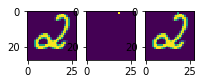

In [88]:
X_noise = np.zeros((1, 28, 28), dtype='float32')
X_noise[0,1,18] = .592156862745098

fuzzy_imgs = (X_samples_2_ONE + X_noise)
fuzzy_imgs = np.clip(fuzzy_imgs, 0, 1)
pred = model.predict(fuzzy_imgs)
pred = np.array( [np.argmax(pred[i]) for i in range(X_samples_2_ONE.shape[0])] )
imgs_idx_used = np.where(pred==6)

imgs_used = X_samples_2_ONE[imgs_idx_used]
noises_used = np.zeros((imgs_used.shape[0], 28, 28))
for i in range(imgs_used.shape[0]):
    noises_used[i] = X_noise

fuzzy_imgs = imgs_used + noises_used

print("Images used: " + str(imgs_idx_used))
print("\nPredicting original images")
pred = [np.argmax(model.predict((imgs_used))[i]) for i in range(imgs_used.shape[0])]
print(pred)

print("\nPredicting images with pertubation")
pred = [np.argmax(model.predict(imgs_fuzzy)[i]) for i in range(imgs_used.shape[0])]
print(pred)

plot_figures(imgs_used, noises_used, num_imgs=len(pred))

Even After making a big process to look what I can do changing just one pixel, the result was the same of my binary search process.

The only difference was that I find the limiar that make class change in the pixel.